In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
import seaborn as sns
from datetime import datetime

In [39]:
df_info = pd.read_csv('colect_data\colect_data\clean_data.csv')
df_info.head()

,Id,Title,Price(Triệu/tháng),Square(m²),District,City,Date
0,478324,Cho thuê phòng để ở tại 108/64A1 Trần Quang Di...,3.50,18.0,Quận 3,Hồ Chí Minh,20/06/2020
1,723089,"Phòng trọ,căn hộ mini đầy đủ tiện nghi ngay tr...",6.00,70.0,Quận 4,Hồ Chí Minh,21/11/2018
2,728993,Phòng vừa xây xong thoáng mát gần các trường Đ...,3.30,25.0,Quận 7,Hồ Chí Minh,17/10/2018
3,745037,Cho nam thuê phòng (ghép) tại quận 10. Nhà ở t...,1.45,8.0,Quận 10,Hồ Chí Minh,03/10/2018
4,781296,Cần share lại gấp phòng trọ mới thuê tại đường...,3.00,15.0,Quận 10,Hồ Chí Minh,05/10/2018


In [40]:
df_info["Date"] = df_info["Date"].str.replace('\n','')
df_info["Date"] = pd.to_datetime(df_info["Date"],format = "%d/%m/%Y ",errors = 'coerce')

Ta nhận thấy rằng các cột có thể tính toán sự phân bố đó là Price(Triệu/tháng), Square(m²), Date, và District. 2 cột Price và Square đã ở dạng số nên có thể tính trực tiếp, còn cột Date phải xử lý.

Với cột Date, ta sẽ không tính trực tiếp mà ta sẽ chuyển nó thành 1 thuộc tính đó là số ngày đăng

In [41]:
#Lấy ngày hôm nay
today = date.today()
today_column = pd.Series(np.full(len(df_info.index),fill_value = today))
today_column = today_column.astype('datetime64[ns]')
df_info["Num_day"] = (today_column - df_info["Date"]).dt.days
df_info.drop(df_info[df_info["Num_day"] < 0].index,inplace = True)


Ta sẽ tính các giá trị:

- Tỉ lệ % (từ 0 đến 100) các giá trị thiếu 
- Giá trị min
- Giá trị lower quartile (phân vị 25)
- Giá trị median (phân vị 50)
- Giá trị upper quartile (phân vị 75)
- Giá trị max

In [42]:
pd.set_option('display.max_columns', None)

num_col_info_df = pd.DataFrame([],index= ["missing_ratio", "min", "lower_quartile", "median", "upper_quartile", "max" ])
col = ['Price(Triệu/tháng)','Square(m²)','Num_day']

for i in col:
    missing = np.array(df_info[i].isna().sum()*100/len(df_info)) #tinh phan tram gia tri thieu
    distribu = np.nanpercentile(df_info[i],(0,25,50,75,100)) #tinh min,lower,median,upper,max
    data = np.append(missing,distribu)
    num_col_info_df[i] = data.round(1)
num_col_info_df

,Price(Triệu/tháng),Square(m²),Num_day
missing_ratio,0.8,2.9,0.9
min,0.0,1.0,6.0
lower_quartile,2.0,18.0,646.5
median,3.0,24.0,962.5
upper_quartile,4.2,30.0,1371.0
max,3000000.0,250.0,1528.0


Với các cột không phải dạng số: Title, District, City, ta sẽ tính:

- Tỉ lệ % (từ 0 đến 100) các giá trị thiếu
- Số lượng giá trị khác nhau
- Giá trị xuất hiện nhiều nhất
- Giá trị xuẩt hiện ít nhất

In [43]:
col = ['Title','District','City']
ob_col_info_df = pd.DataFrame([],index = ['missing ratio','num diff value','Most appear','Min appear'])

for i in col:
    missing = np.array(df_info[i].isna().sum()*100/len(df_info)) #tinh phan tram gia tri thieu
    diff_value = len(df_info[i].dropna().unique())
    count_value = df_info[i].dropna().value_counts()
    most_ap = count_value[0]
    least_ap = count_value[-1]
    ob_col_info_df[i] = [missing,diff_value,most_ap,least_ap]
ob_col_info_df

,Title,District,City
missing ratio,0.0,0.0,0.0
num diff value,1185,23,1
Most appear,1,183,1185
Min appear,1,2,1185


Ta sẽ vẽ một vài biểu đồ để xem xét rõ hơn sự phân bố

In [44]:
#Hàm vẽ
def draw_chart(df_col,til,x_name,y_name,typechart = 0):
    #Tính tần số và sắp xếp giảm dần
    data_num = df_col.value_counts()

    #Kiểm tra xem có phải là dạng barh không
    if typechart==1:
        plt.barh(data_num.index,data_num.values,height= 0.5)
    else:
        plt.bar(data_num.index,data_num.values)
        
    plt.title(til)
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.show()

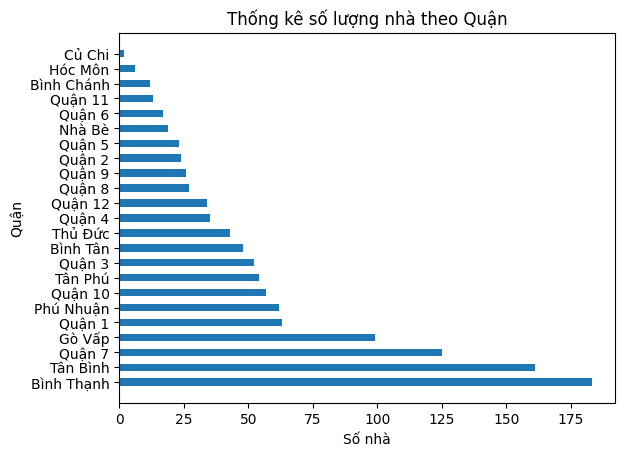

In [45]:
draw_chart(df_info["District"],"Thống kê số lượng nhà theo Quận","Số nhà","Quận",1)

Giá trị nhà ảo là những giá trị thuê lớn hơn 100, ta sẽ bỏ đi những dòng này để tránh gây ảnh hưởng đến dữ liệu

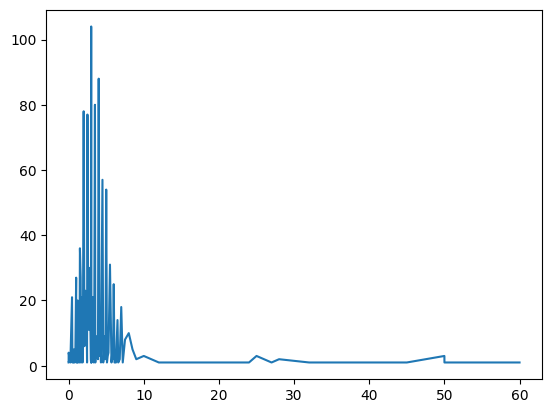

In [46]:
#Chia thành từng khoảng 1 triệu

df_info.drop(df_info[df_info["Price(Triệu/tháng)"]>100].index,inplace=True)
count_price = df_info["Price(Triệu/tháng)"].value_counts()
count_price = count_price.sort_index()
plt.plot(count_price.index,count_price.values)
plt.show()

Ta thấy dữ liệu tập trung chủ yếu từ 0 đến 10 triệu, vậy ta sẽ lấy dữ liệu khoảng này để vẽ rõ hơn ( vẽ bằng bar chart )

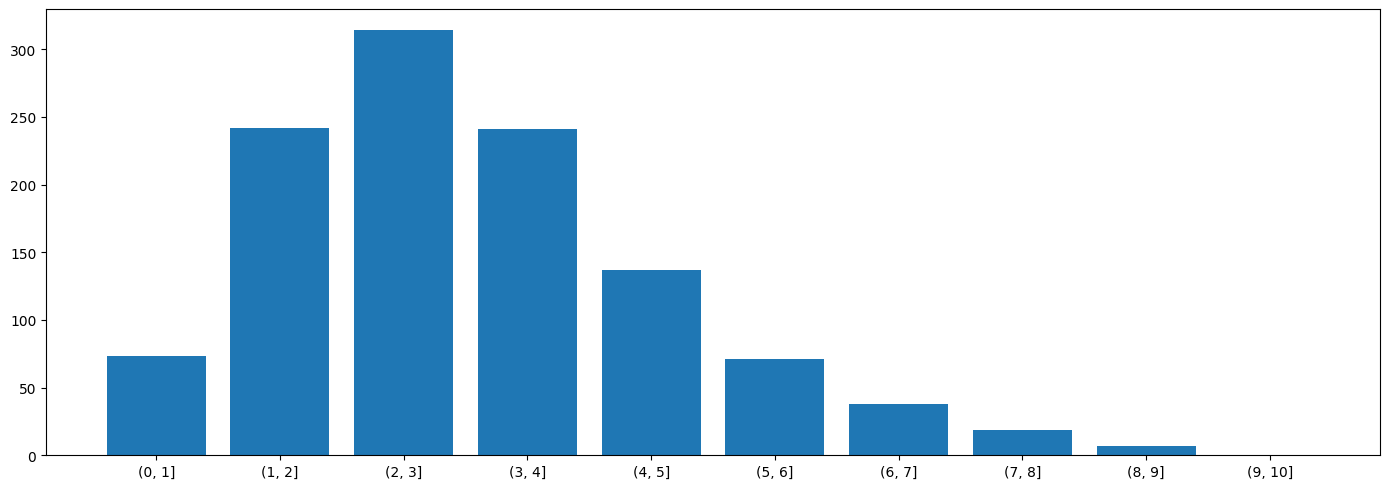

In [47]:
price_10 = df_info[df_info["Price(Triệu/tháng)"]<10]["Price(Triệu/tháng)"]
price_list_range = np.arange(0,11,1)

range_price_10 = pd.cut(price_10,bins = price_list_range)

count_price_10 = range_price_10.value_counts().sort_index()
count_price_10 = count_price_10.reset_index()
count_price_10.columns = ["Range","So luong"]
count_price_10["Range"] = count_price_10["Range"].astype(str)

plt.subplots(figsize = (14,5))
plt.bar(count_price_10["Range"],count_price_10["So luong"])
plt.tight_layout()
plt.show()


Ta cũng vẽ đồ thị biểu diễn số lượng nhà theo diện tích

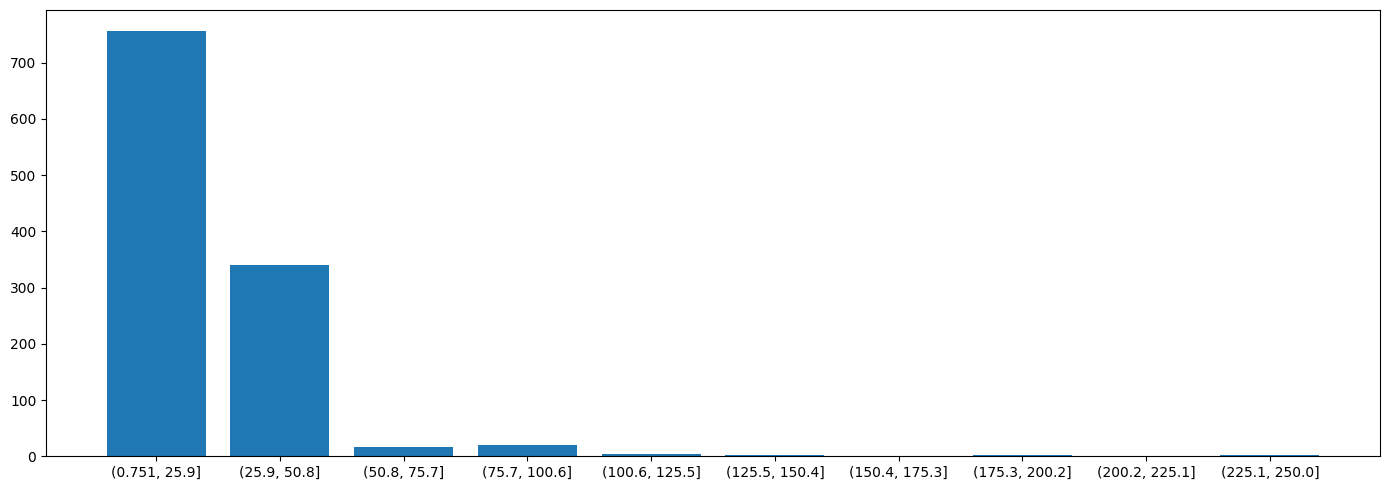

In [48]:
a = df_info["Square(m²)"].dropna()
b = pd.cut(a.values,bins=10)

c = b.value_counts().sort_index()
c = c.reset_index()
c.columns = ["Range","So luong"]
c["Range"] = c["Range"].astype(str)
plt.subplots(figsize = (14,5))
plt.bar(c["Range"],c["So luong"])
plt.tight_layout()
plt.show()

Dữ liệu tập trung nhiều ở khoảng dưới 70, vậy ta sẽ dùng dữ liệu khoảng này để vẽ lại rõ hơn

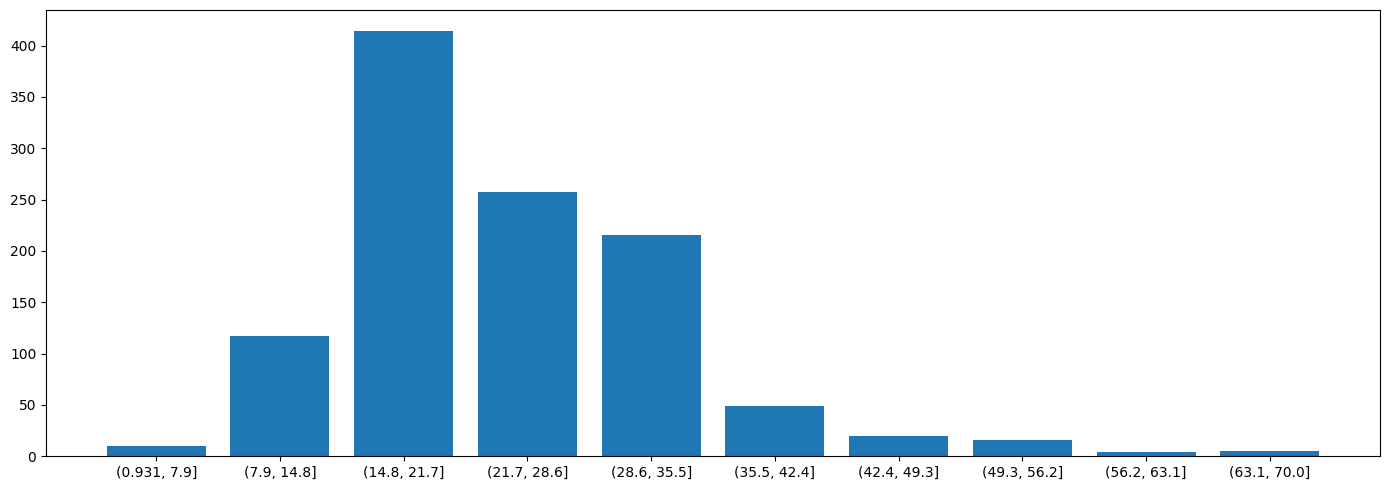

In [49]:
square150 =  df_info[df_info["Square(m²)"] <= 70]["Square(m²)"]
range_square150 = pd.cut(square150,bins = 10)

count_square150 = range_square150.value_counts().sort_index()
count_square150 = count_square150.reset_index()
count_square150.columns = ["Range","So luong"]
count_square150["Range"] = count_square150["Range"].astype(str)
plt.subplots(figsize = (14,5))
plt.bar(count_square150["Range"],count_square150["So luong"])
plt.tight_layout()
plt.show()

Ta thường có quan niệm rằng diện tích càng lớn thì giá nhà càng cao, vậy ta thử vẽ đồ thị scatterplot để xem mối liên hệ này có đúng không

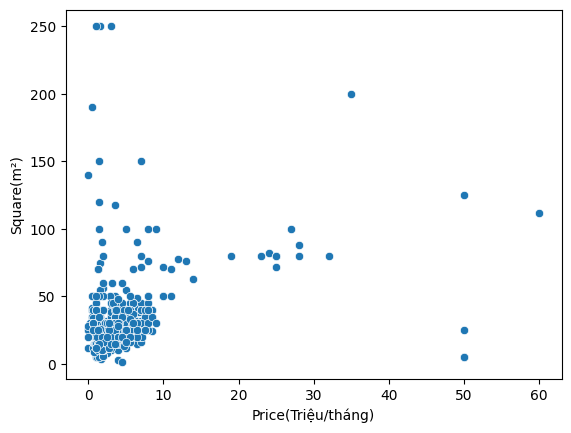

In [50]:
df_data = df_info[["Price(Triệu/tháng)","Square(m²)"]]
sns.scatterplot(df_data,x = df_data["Price(Triệu/tháng)"],y = df_data["Square(m²)"])
plt.show()

Điểm dữ liệu tập trung nhiều ở Square dưới 100 và Price dưới 10, ta sẽ lấy dữ liệu ở những khoảng này để vẽ rõ hơn

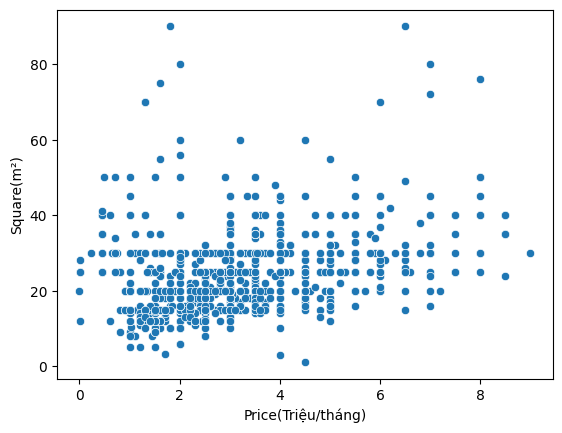

In [51]:
df_data = df_info[["Price(Triệu/tháng)","Square(m²)"]]
df_price_square = df_data[df_data["Price(Triệu/tháng)"] < 10]
df_price_square = df_price_square[df_price_square["Square(m²)"] < 100]
sns.scatterplot(df_price_square,x = df_price_square["Price(Triệu/tháng)"],y = df_price_square["Square(m²)"])
plt.show()

Quan sát đồ thị trên, ta thấy có vẻ rằng mối liên hệ này không hẳn đúng (trong tập dữ liệu này) khi không có thể đường tuyến tính nào cả. Vậy chắc hẳn ngoài diện tích thì còn nhiều yếu tố khác tác động lên giá nhà

Thống kê giá nhà trung bình của các quận theo từng năm.

In [52]:
df_info.head()

,Id,Title,Price(Triệu/tháng),Square(m²),District,City,Date,Num_day
0,478324,Cho thuê phòng để ở tại 108/64A1 Trần Quang Di...,3.50,18.0,Quận 3,Hồ Chí Minh,2020-06-20,898.0
1,723089,"Phòng trọ,căn hộ mini đầy đủ tiện nghi ngay tr...",6.00,70.0,Quận 4,Hồ Chí Minh,2018-11-21,1475.0
2,728993,Phòng vừa xây xong thoáng mát gần các trường Đ...,3.30,25.0,Quận 7,Hồ Chí Minh,2018-10-17,1510.0
3,745037,Cho nam thuê phòng (ghép) tại quận 10. Nhà ở t...,1.45,8.0,Quận 10,Hồ Chí Minh,2018-10-03,1524.0
4,781296,Cần share lại gấp phòng trọ mới thuê tại đường...,3.00,15.0,Quận 10,Hồ Chí Minh,2018-10-05,1522.0


In [53]:
df_info_2 = df_info.copy()
df_info_2['Year'] = df_info_2['Date'].astype(str).str.slice(0,4)
df_info_2['Year'].unique()

array(['2020', '2018', 'NaT', '2019', '2021', '2022'], dtype=object)

Cột dữ liệu Date tồn tại giá trị NaT. Xóa những dòng có Date không xác định

In [54]:
df_info_2 = df_info_2[df_info_2['Date'].notnull()]

In [55]:
district_group = df_info_2.groupby(['District','Year'])['Price(Triệu/tháng)'].mean()
pd.set_option('display.max_rows', None)
district_group

District    Year
Bình Chánh  2018     2.100000
            2019     4.500000
            2020     2.000000
            2021     2.066667
            2022     3.850000
Bình Thạnh  2018     3.004717
            2019     3.559375
            2020     3.361429
            2021     3.502381
            2022     4.448276
Bình Tân    2018     2.200000
            2019     2.620000
            2020     1.937583
            2021     2.350000
            2022     2.650000
Củ Chi      2019     0.900000
            2021     2.000000
Gò Vấp      2018     3.020588
            2019     2.616667
            2020     2.727778
            2021     2.660870
            2022     3.507143
Hóc Môn     2018     1.800000
            2019     1.550000
            2020     1.950000
            2022     1.600000
Nhà Bè      2018     4.033333
            2019     2.750000
            2020     2.537500
            2021     3.200000
            2022     2.800000
Phú Nhuận   2018     5.633333
            2019     5.

In [56]:
mean_price_each_district_each_year = district_group.values

In [57]:
groups_key = district_group.keys()
cities = [city[0] for city in groups_key]
cities = np.unique(cities)
len(cities)

23

In [58]:
years = np.arange(0, 5) + 2018 
data = {}
j = 0
for i in range(20):
    data[cities[i]] = mean_price_each_district_each_year[j:j + 5]
    j = i + 5
category_names = np.arange(5) + 2018

In [59]:
data

{'Bình Chánh': array([2.1       , 4.5       , 2.        , 2.06666667, 3.85      ]),
 'Bình Thạnh': array([3.00471698, 3.559375  , 3.36142857, 3.50238095, 4.44827586]),
 'Bình Tân': array([3.559375  , 3.36142857, 3.50238095, 4.44827586, 2.2       ]),
 'Củ Chi': array([3.36142857, 3.50238095, 4.44827586, 2.2       , 2.62      ]),
 'Gò Vấp': array([3.50238095, 4.44827586, 2.2       , 2.62      , 1.93758333]),
 'Hóc Môn': array([4.44827586, 2.2       , 2.62      , 1.93758333, 2.35      ]),
 'Nhà Bè': array([2.2       , 2.62      , 1.93758333, 2.35      , 2.65      ]),
 'Phú Nhuận': array([2.62      , 1.93758333, 2.35      , 2.65      , 0.9       ]),
 'Quận 1': array([1.93758333, 2.35      , 2.65      , 0.9       , 2.        ]),
 'Quận 10': array([2.35      , 2.65      , 0.9       , 2.        , 3.02058824]),
 'Quận 11': array([2.65      , 0.9       , 2.        , 3.02058824, 2.61666667]),
 'Quận 12': array([0.9       , 2.        , 3.02058824, 2.61666667, 2.72777778]),
 'Quận 2': array([2.   

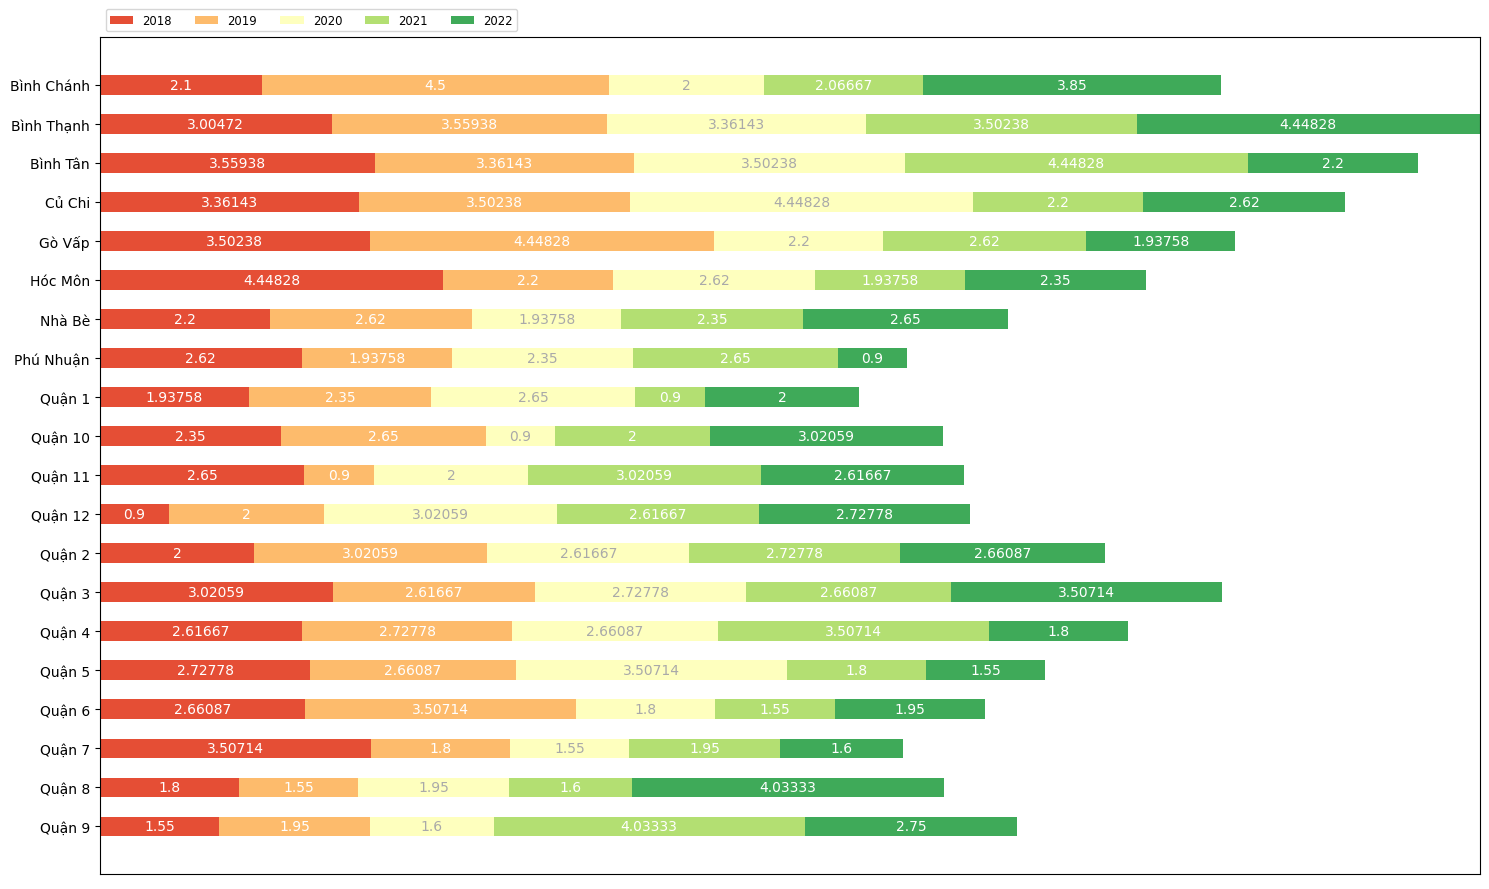

In [60]:
def survey(results, category_names):
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.colormaps['RdYlGn'](
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(15, 9))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, height=0.5,
                        label=colname, color=color)

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        ax.bar_label(rects, label_type='center', color=text_color)
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')

    return fig, ax


survey(data, category_names)
plt.tight_layout()
plt.show()